In [ ]:
pip install salib

     |████████████████████████████████| 860kB 5.7MB/s 
  Created wheel for salib: filename=SALib-1.3.12-py2.py3-none-any.whl size=729049 sha256=0bc3e0548d140511d5963796587d5eeea6ec9b78fa9741f64570a751905ceb67
  Stored in directory: /root/.cache/pip/wheels/04/5c/9f/09d58ab84d5a7ef7d2e5fedc5cd2f46a64a77c99035571aa0c
Successfully built salib


In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
import numpy as np
import pandas as pd
import pylab as plt
from scipy.integrate import solve_ivp 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Definindo o modelo:

In [ ]:
## Função betad(t):
def betad(t, b5, b6, k, x0):
        return (b5 - b6) /(1 + np.exp(-k * (t - x0))) + b6

In [ ]:
def deltadt(t, d_0,d_1, mu, dat):
      return (d_0 - d_1)/(1 + np.exp(-mu*( -t +dat))) + d_1

In [ ]:
def SEIR(t,y,p,q, b5, b6, k, x0,gama, gamaD, d_0, d_1, mu, dat, sigma):
  S,E,I,Id,R,Rd, D = y
  dydt = [-betad(t, b5, b6, k, x0)*S*(I + q*Id),betad(t, b5, b6, k, x0)*S*(I + q*Id) - sigma*E, 
        (1-p)*sigma*E - gama*I, p*sigma*E -gamad*Id -deltadt(t, d_0,d_1, mu, dat)*gamad*Id/(1-deltadt(t, d_0, d_1, mu, dat)),
                gama*I,gamad*Id, deltadt(t, d_0, d_1, mu, dat)*gamad*Id/(1- deltadt(t, d_0, d_1, mu, dat)) ]
  return dydt

Definindo os parâmetros do modelo:

In [ ]:
params = {
'p': 0.063,
'q': 0.69,
'b5': 0.26,
'b6': 0.21, 
'k': 0.25,
'x0': 70, 
'gama': 1/7,
'gamad': 1/10,
'd_0': 0.052,
'd_1': 0.012, 
'mu': 0.09,
'dat': 3.7, 
'sigma': 1/5,
}

#condições iniciais
inits = [.999, 0, 0.001, 0, 0, 0, 0]
t = np.arange(301)

Rodando o modelo:

In [ ]:


X_SEIR = solve_ivp(SEIR, t_span=[t[0], t[-1]], y0 = inits, t_eval = t, args=(np.array(list(params.values()))))

Plotando o resultado:

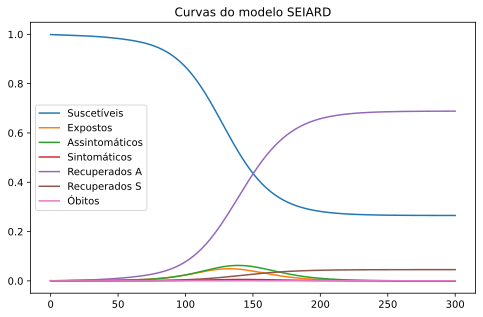

In [ ]:
S_SEIR = X_SEIR.y[0]
E_SEIR = X_SEIR.y[1]
I_SEIR = X_SEIR.y[2]
Id_SEIR = X_SEIR.y[3]
R_SEIR = X_SEIR.y[4]
Rd_SEIR = X_SEIR.y[5]
D_SEIR = X_SEIR.y[6]

plt.figure(figsize=(8,5))
plt.title("Curvas do modelo SEIARD")
plt.plot(t, S_SEIR, label = 'Suscetíveis')
plt.plot(t, E_SEIR, label = 'Expostos')
plt.plot(t, I_SEIR, label = 'Infectados não identificados')
plt.plot(t, Id_SEIR, label = 'Infectados identificados')
plt.plot(t, R_SEIR, label = 'Recuperados ')
plt.plot(t, Rd_SEIR, label = 'Recuperados identificados')
plt.plot(t, D_SEIR, label = 'Óbitos')

plt.legend()

plt.show()

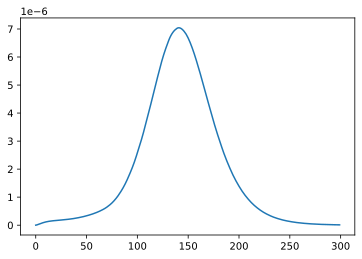

In [ ]:
plt.plot(np.diff(D_SEIAR))

# Definindo a análise


In [ ]:
problem = {
    'num_vars': 13,
    'names': list(params.keys()),
    'bounds': [[0,1],[0,1],[0,1], [0,1], [0,2], [30,100],[0.07,0.20],[0.037,0.140],[0.001,0.07], [0.001,0.07], [0,0.6], [0,50],
              [0.14,0.34]]
}

## Gerando as amostras


In [ ]:
param_values = saltelli.sample(problem, 1000)

In [ ]:
param_values.shape

(28000, 13)

## Rodando o modelo

Para fazer a análise de sensibilidade precisamos selecionar um aspecto da saída do model, sobre o qual desejamos estudar a variância em resposta à varância dos parâmetros. Para este caso simples, vamos escolher o valor de pico de $I(t)$.

In [ ]:
def eval_model(parametros):
    #parms = dict(zip(params.keys(),parametros))
    #mod = cm.SEQIAHR()
    #mod(inits=inits, trange = [0,200], totpop=1, params=parms)
    #Y = max(mod.traces['I'])
    X_SEIR = solve_ivp(SEIR, t_span=[t[0], t[-1]], y0 = inits, t_eval = t, args=(parametros))
    Id_SEIR = X_SEIR.y[3]
    Rd_SEIR = X_SEIR.y[5]
    D_SEIR = X_SEIR.y[6]
    C = Id_SEIR + Rd_SEIR + D_SEIR
    Y = max(Is_SEIR) 
    return Y

Para acelerar a execução dos cenários, vamos paralelizar a simulação do modelo

In [ ]:
from multiprocessing import Pool

In [ ]:
Po = Pool()
Y = Po.map(eval_model, param_values)

In [ ]:
Po.close()

In [ ]:
Si = sobol.analyze(problem, np.array(Y), print_to_console=False)

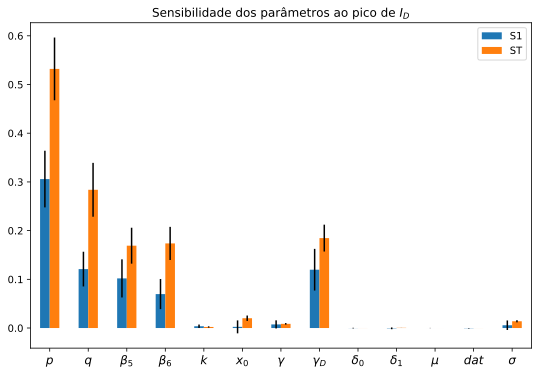

In [ ]:
def plot_sobol(si,prob, order=1):
    Si_filter = {k:si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    fig, ax = plt.subplots(1, figsize=(9,6))

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)

    ax.set_title(r"Sensibilidade dos parâmetros ao pico de $I_D$")

    ax.set_xticklabels((r'$p$',r'$q$',r'$\beta_5$',r'$\beta_6$',r'$k$',r'$x_0$',r'$\gamma$',r'$\gamma_D$',r'$\delta_0$',r'$\delta_1$', r'$\mu$', r'$dat$', r'$\sigma$'), fontsize = 12)
    ax.tick_params(axis='x', rotation=0)


    return fig
fig = plot_sobol(Si,problem)
fig.savefig("Sensibilidade_2I_D_D.svg")

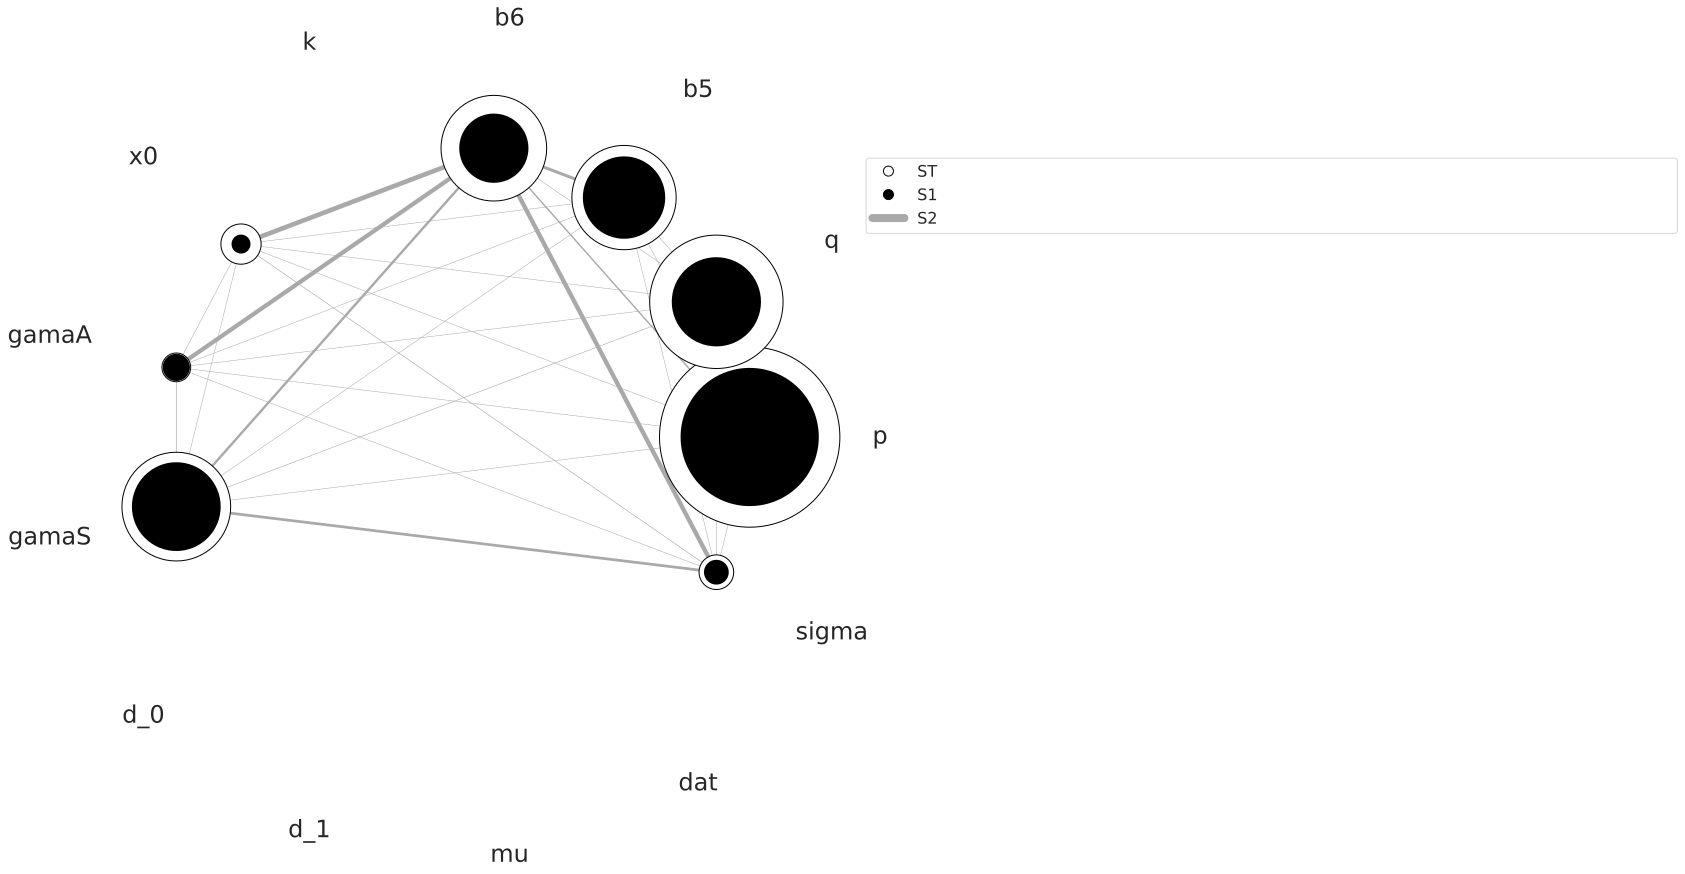

In [ ]:
import itertools
from math import pi
from matplotlib.legend_handler import HandlerPatch


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names, fontsize=24)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig



class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand', fontsize=16,
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)